# Plotting Code for the WRF Single Column Model Output

In [ ]:
import xarray as xr
import xwrf as xw
import proplot as pplt
import matplotlib.pyplot as plt
import scm_helper 
import numpy as np

## 1.) Copying the data over from our WRF run.

Once the `wrf.exe` is finished running, you should find a new file titled `wrfout_d01_1999-10-22_19:00:00`.

Because the data in the `WRF/test/em_scm_xy/` directory is not saved, you'll want to copy it over into a directory that will persist even after you logout of the JupyterHub.  Let's do that now.

In [15]:
output_file = "/home/jovyan/WRF/WRF/test/em_scm_xy/wrfout_d01_1999-10-22_19:00:00"
directory = "/home/jovyan/WRF_out/wrfout_ysu"
os.system(f"cp {output_file} {directory}")

NameError: name 'os' is not defined

## 2.) Loading in the data

The output file format from the WRF is usually in the NetCDF format.  This is a format that has multi-dimensional arrays.  There is also metadata that can help you understand the dimensions, units, etc.

Here we'll load in the dataset that we have obtained from our run of `./wrf.exe`.  This code will also determine what PBL scheme you used in your run.

In [136]:
d = xr.open_dataset('wrfout_mynn_5_5').xwrf.postprocess()
d = d.xwrf.destagger()
bl = scm_helper.get_pbl_name(d)
scheme = bl[1]

print("Your Boundary Layer Scheme:", bl)
d

Your Boundary Layer Scheme: ('MYNN 2.5 level TKE scheme', 'MYNN v2.5')


<xarray.Dataset> Size: 2MB
Dimensions:                    (Time: 60, y: 2, x: 2, soil_layers: 3, z: 59,
                                seed_dim: 7, x_stag: 3, y_stag: 3, z_stag: 60)
Coordinates: (12/15)
    XLAT                       (y, x) float32 16B 37.6 37.6 37.6 37.6
    XLONG                      (y, x) float32 16B -96.7 -96.7 -96.7 -96.7
    XTIME                      (Time) datetime64[ns] 480B ...
    XLAT_U                     (y, x_stag) float32 24B 0.0 0.0 0.0 0.0 0.0 0.0
    XLONG_U                    (y, x_stag) float32 24B 0.0 0.0 0.0 0.0 0.0 0.0
    XLAT_V                     (y_stag, x) float32 24B 0.0 0.0 0.0 0.0 0.0 0.0
    ...                         ...
  * z_stag                     (z_stag) float32 240B 1.0 0.9925 ... 0.03201 0.0
  * Time                       (Time) datetime64[ns] 480B 1999-10-22T19:00:00...
  * y_stag                     (y_stag) float64 24B -4e+03 0.0 4e+03
  * y                          (y) float64 16B -2e+03 2e+03
  * x_stag                     (x_stag) float64 24B -4e+03 0.0 4e+03
  * x                          (x) float64 16B -2e+03 2e+03
Dimensions without coordinates: soil_layers, seed_dim
Data variables: (12/182)
    Times                      (Time) |S19 1kB b'1999-10-22_19:00:00' ... b'1...
    LU_INDEX                   (Time, y, x) float32 960B ...
    ZS                         (Time, soil_layers) float32 720B 0.15 ... 1.1
    DZS                        (Time, soil_layers) float32 720B 0.2 0.45 ... 0.8
    VAR_SSO                    (Time, y, x) float32 960B ...
    BATHYMETRY_FLAG            (Time) int32 240B ...
    ...                         ...
    geopotential               (Time, z, y, x) float32 57kB 251.0 ... 1.136e+05
    geopotential_height        (Time, z, y, x) float32 57kB 25.59 ... 1.158e+04
    wind_east                  (Time, z, y, x) float32 57kB 3.0 3.0 ... 3.0 3.0
    wind_north                 (Time, z, y, x) float32 57kB -9.0 -9.0 ... -9.0
    wind_east_10               (Time, y, x) float32 960B 0.0 0.0 ... 2.46 2.46
    wind_north_10              (Time, y, x) float32 960B 0.0 0.0 ... -1.951
Attributes: (12/134)
    TITLE:                            OUTPUT FROM WRF V4.4.2 MODEL
    START_DATE:                      1999-10-22_19:00:00
    SIMULATION_START_DATE:           1999-10-22_19:00:00
    WEST-EAST_GRID_DIMENSION:        3
    SOUTH-NORTH_GRID_DIMENSION:      3
    BOTTOM-TOP_GRID_DIMENSION:       60
    ...                              ...
    ISLAKE:                          0
    ISICE:                           0
    ISURBAN:                         0
    ISOILWATER:                      0
    HYBRID_OPT:                      0
    ETAC:                            0.0

## 3.) Loading in variables from your single column model (SCM).

We'll now have to load in individual variables from our SCM run.  Let's load in a few different variables:

* potential temperature (theta)
* water vapor mixing ratio (qvapor)
* height
* u, v wind components.
* contributions to the temperature tendency from the PBL scheme.

In [138]:

theta = d.variables['air_potential_temperature']
pbl_theta = d.variables['RTHBLTEN']
pbl_qv = d.variables['RQVBLTEN']
pbl_u = d.variables['RUBLTEN']
pbl_v = d.variables['RVBLTEN']
qvapor = d.variables['QVAPOR']
u_wind = d.variables['wind_east']
v_wind = d.variables['wind_north']

# Look for a TKE variable.  If there isn't any, set it equal to zero.
if d.variables.get('QKE') is not None:
    tke_pbl = d.variables['QKE']
elif d.variables.get('TKE_PBL') is not None:
    tke_pbl = d.variables['TKE_PBL']
else:
    tke_pbl = np.zeros(theta.shape)
    
if d.variables.get("EL_PBL") is not None:
    el_pbl = d.variables['EL_PBL']
else:
    el_pbl = np.zeros(theta.shape)
    
if d.variables.get("WU_TUR") is not None:
    wu_tur = d.variables['WU_TUR']
else:
    wu_tur = np.zeros(theta.shape)
    
if d.variables.get("WV_TUR") is not None:  
    wv_tur = d.variables['WV_TUR']
else:
    wv_tur = np.zeros(theta.shape)
    
if d.variables.get("WT_TUR") is not None:
    wt_tur = d.variables['WT_TUR']
else:
    wt_tur = np.zeros(theta.shape) 
    
if d.variables.get("WQ_TUR") is not None:
    wq_tur = d.variables['WQ_TUR']
else:
    wq_tur = np.zeros(theta.shape)

if d.variables.get('TSQ') is not None:
    tsq = d.variables['TSQ']
else:
    tsq = np.zeros(theta.shape)
    
if d.variables.get('QSQ') is not None:
    qsq = d.variables['QSQ']
else:
    qsq = np.zeros(theta.shape)
    
if d.variables.get('COV') is not None:
    cov = d.variables['COV']
else:
    cov = np.zeros(theta.shape)
    
if d.variables.get('SH3D') is not None:
    sh3d = d.variables['SH3D']
else:
    sh3d = np.zeros(theta.shape)
    
#state   real   tsq             ikj     misc        1         -      rh        "tsq"               "liquid water pottemp variance"      "K2"
#state   real   qsq             ikj     misc        1         -      rh        "qsq"               "total water variance"      "(kg/kg)**2"
#state   real   cov             ikj     misc        1         -      rh        "cov"               "total water-liquid water pottemp covariance"   "K kg/kg"
#state   real   Sh3d            ikj     misc        1         -      rh        "Sh3d"              "Stability function for heat"   ""


## 4.) Plotting Time x Height Cross Section for Potential Temperature

/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/3821279253.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


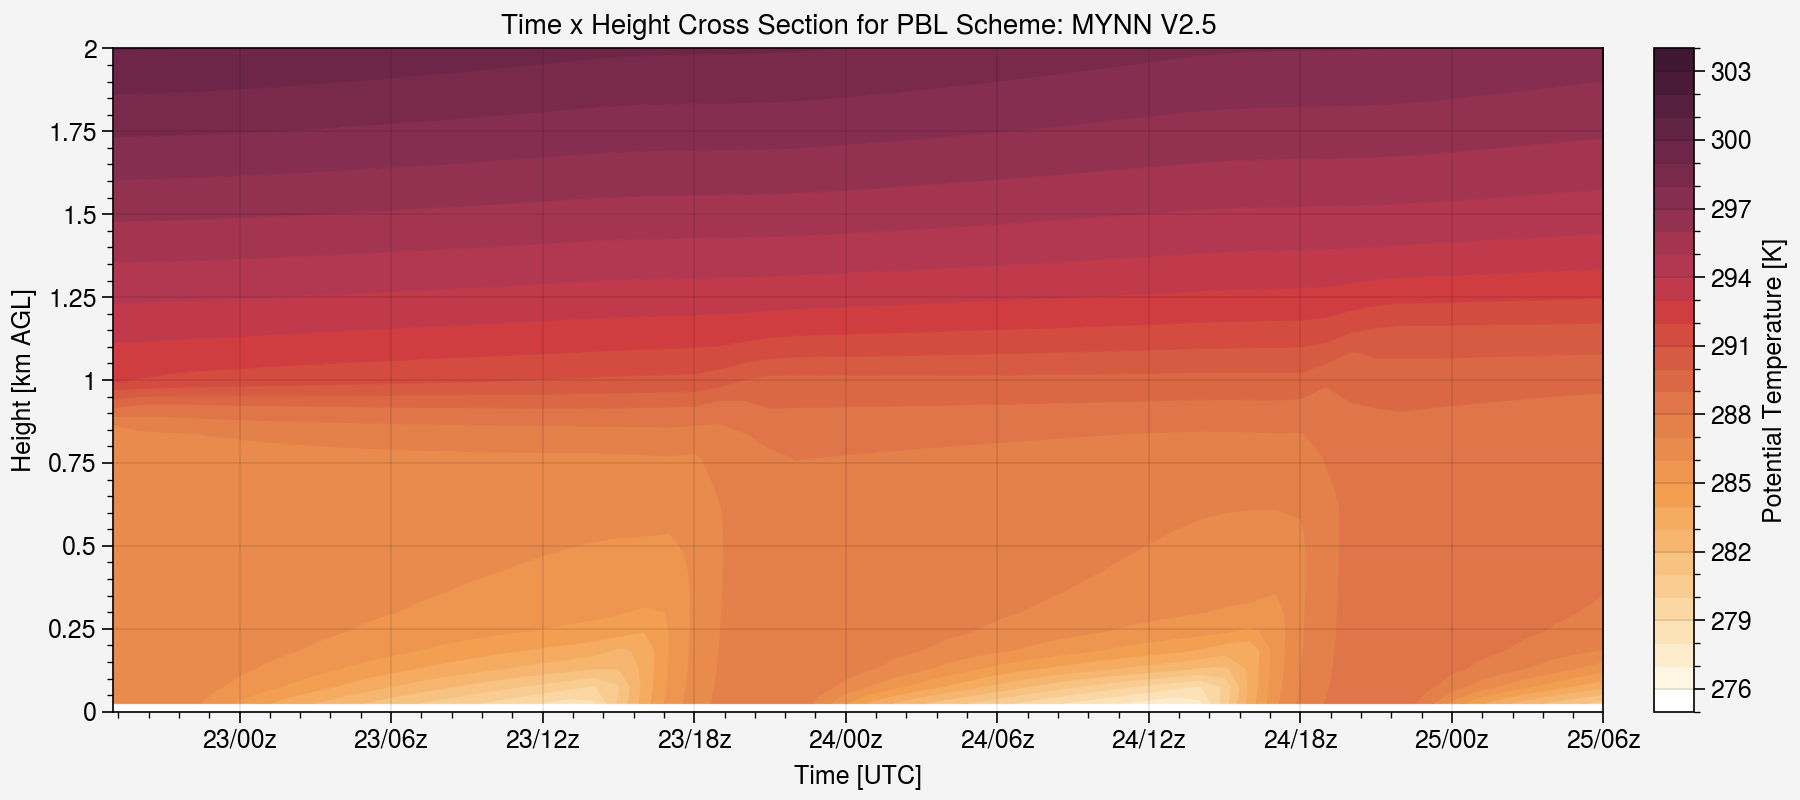

In [163]:
fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
fig.format(title=f"Time x Height Cross Section for PBL Scheme: {scheme.upper()}")
#c = axs.contourf(d['Time'].values, d['geopotential_height'].T[:, :, 0, 0].values, theta[:, :, 0, 0].T.values, levels=np.arange(275, 300, 1), cmap='plasma')

# Ensure the data shapes are correct for contourf
time_values = d['Time'].values
height_values = d['geopotential_height'][0, :, 0, 0].values / 1000.
theta_values = theta[:, :, 0, 0].T.values
c = plt.contourf(time_values, height_values, theta_values, levels=np.arange(275, 305, 1))

#barbs(theta.Time, height[0,:,0,0], u[:,:,0,0].T, v[:,:,0,0].T, wspd, cmap='Greys', length=4)
cb = axs.colorbar(c, label="Potential Temperature [K]")
axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
fig.show()



## 4.) Plotting Time x Height Cross Section for Potential Temperature Tendency from PBL Scheme

/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/951195913.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


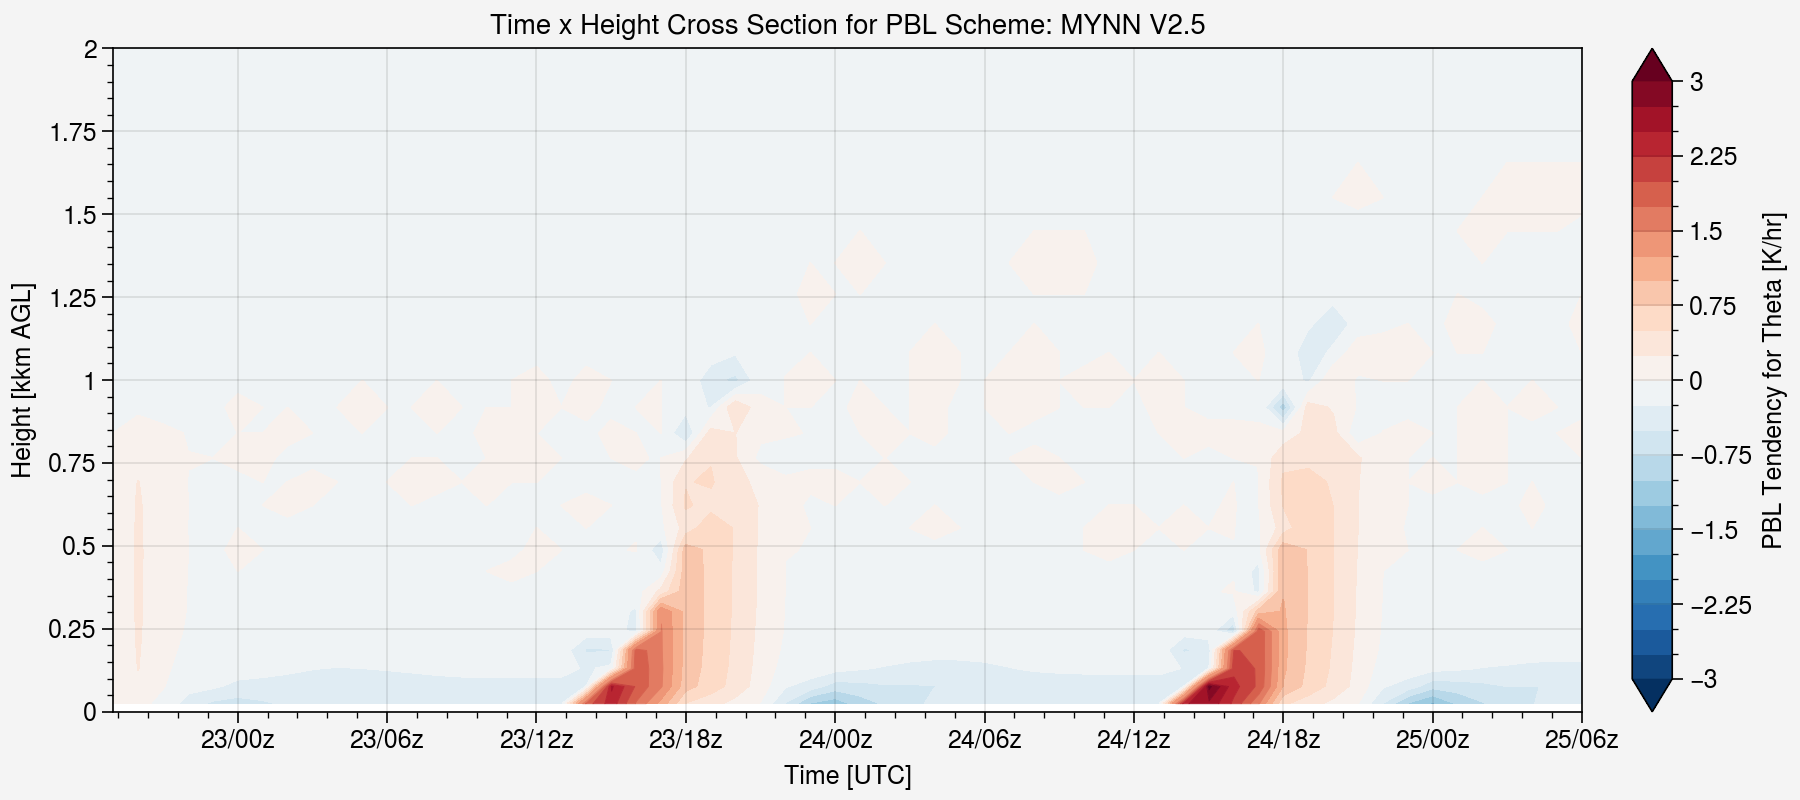

In [164]:
fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
fig.format(title=f"Time x Height Cross Section for PBL Scheme: {scheme.upper()}")
time_values = d['Time'].values
height_values = d['geopotential_height'][0, :, 0, 0].values / 1000.
tend = 3600*pbl_theta[:,:,0,0].T
c = plt.contourf(time_values, height_values, tend, levels=np.arange(-3,3.25,.25), extend='both')

#barbs(theta.Time, height[0,:,0,0], u[:,:,0,0].T, v[:,:,0,0].T, wspd, cmap='Greys', length=4)
cb = axs.colorbar(c, label="PBL Tendency for Theta [K/hr]")
axs.format(ylim=(0, 2), ylabel="Height [kkm AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
fig.show()

## 5.) Plotting Time x Height Cross Section for Water Vapor Mixing Ratio

/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/2661081311.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


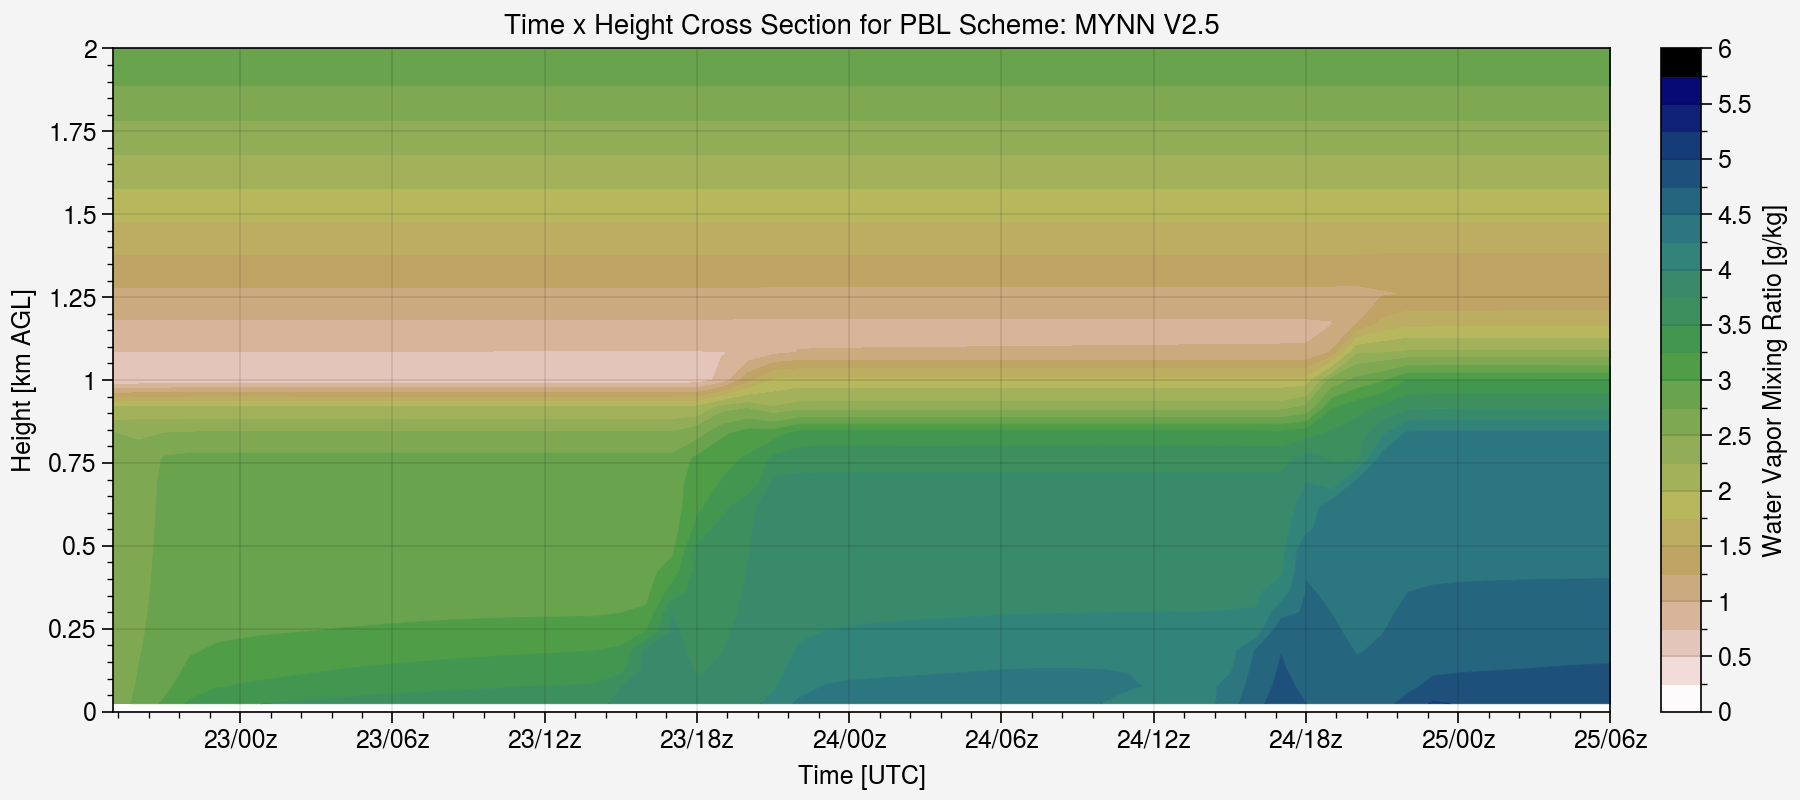

In [165]:
fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
fig.format(title=f"Time x Height Cross Section for PBL Scheme: {scheme.upper()}")
time_values = d['Time'].values
height_values = d['geopotential_height'][0, :, 0, 0].values / 1000.
tend = 1000*qvapor[:,:,0,0].T
c = plt.contourf(time_values, height_values, tend, levels=np.arange(0,6.25,.25), cmap='gist_earth_r')

cb = axs.colorbar(c, label="Water Vapor Mixing Ratio [g/kg]")
axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
fig.show()

/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/3201861738.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


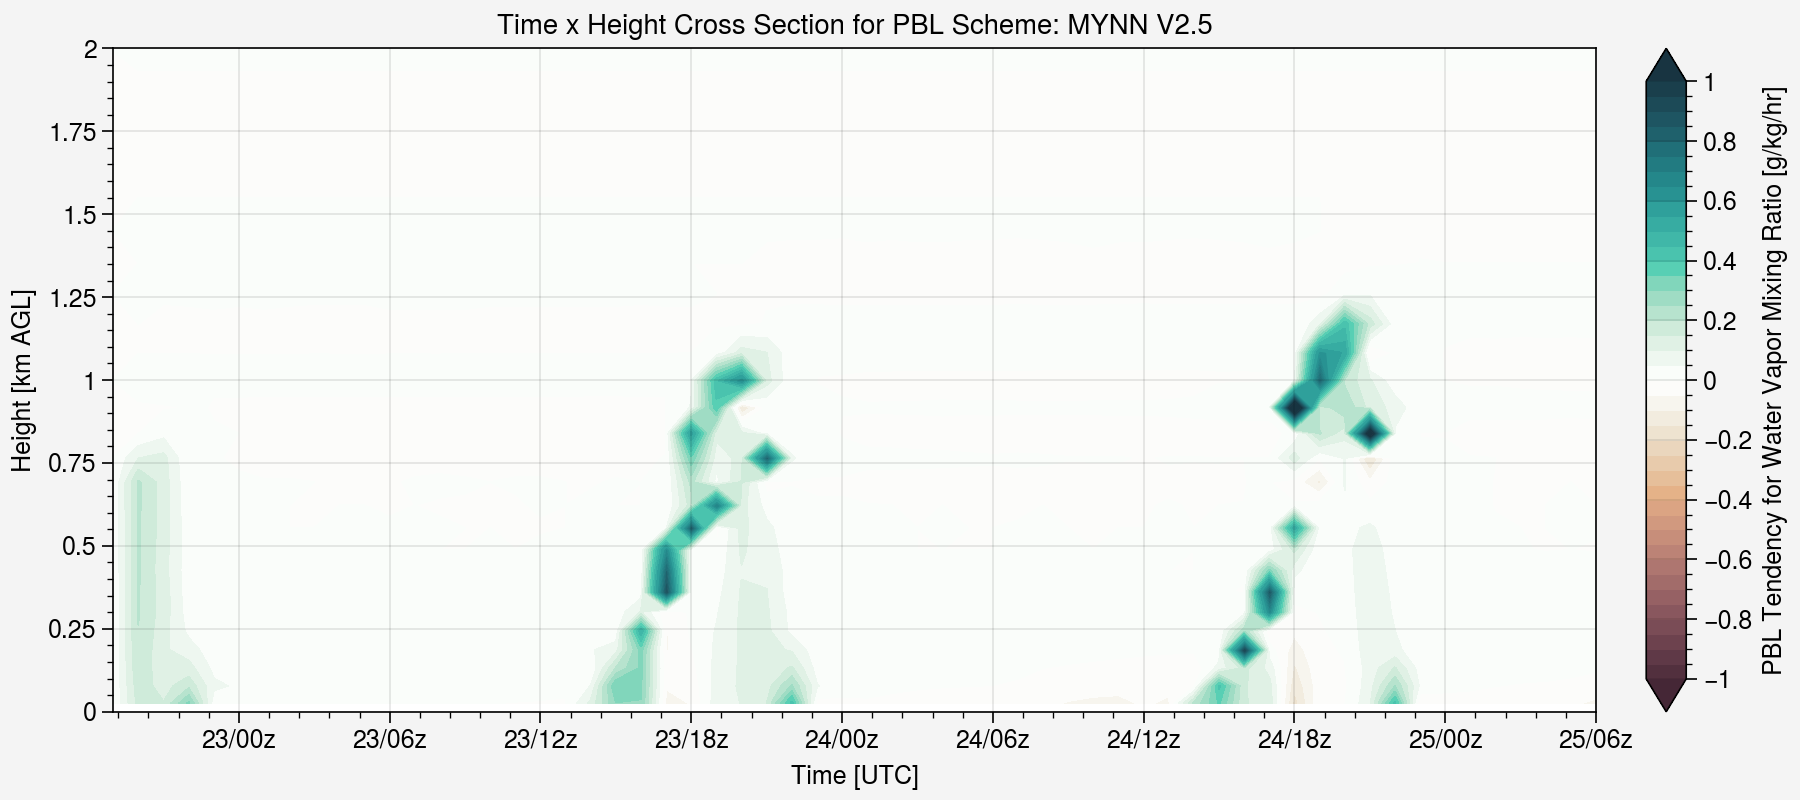

In [166]:
# Plotting Time x Height Cross Section for Water Vapor Mixing Ratio Tendency from PBL Scheme
fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
fig.format(title=f"Time x Height Cross Section for PBL Scheme: {scheme.upper()}")
time_values = d['Time'].values
height_values = d['geopotential_height'][0, :, 0, 0].values / 1000.
qv_tend = 3600 * 1000* pbl_qv[:, :, 0, 0].T
c = plt.contourf(time_values, height_values, qv_tend, levels=np.arange(-1.0, 1.05, 0.05), cmap='DryWet', extend='both')

cb = axs.colorbar(c, label="PBL Tendency for Water Vapor Mixing Ratio [g/kg/hr]", extend='both')
axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
fig.show()

# Plotting Time x Height Cross Section for U Wind Component

/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/2058358757.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/2058358757.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


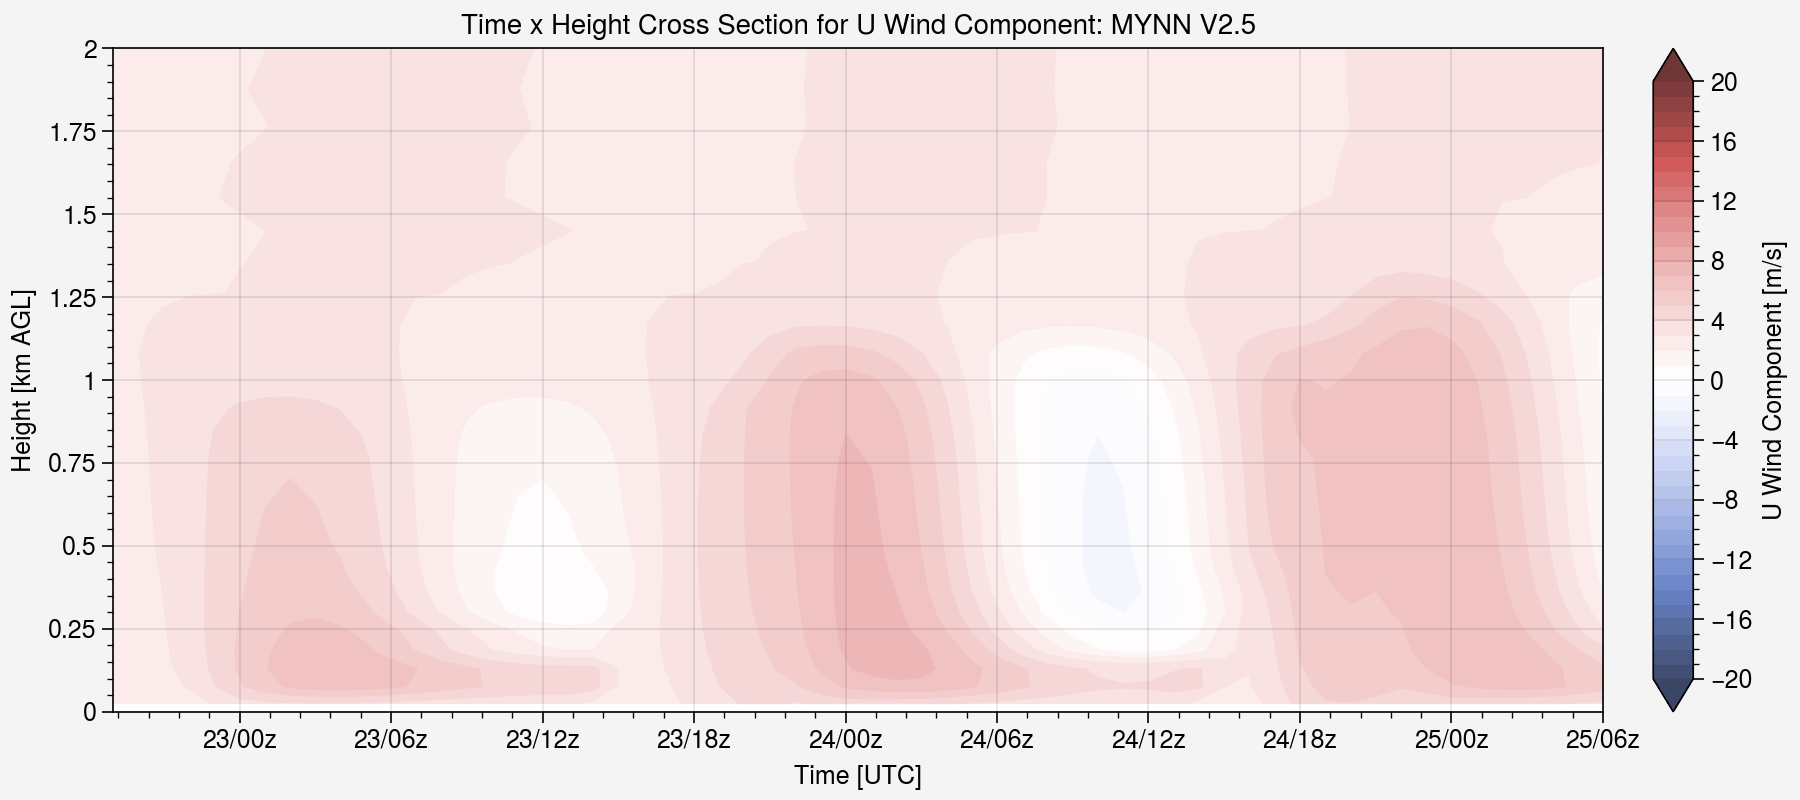

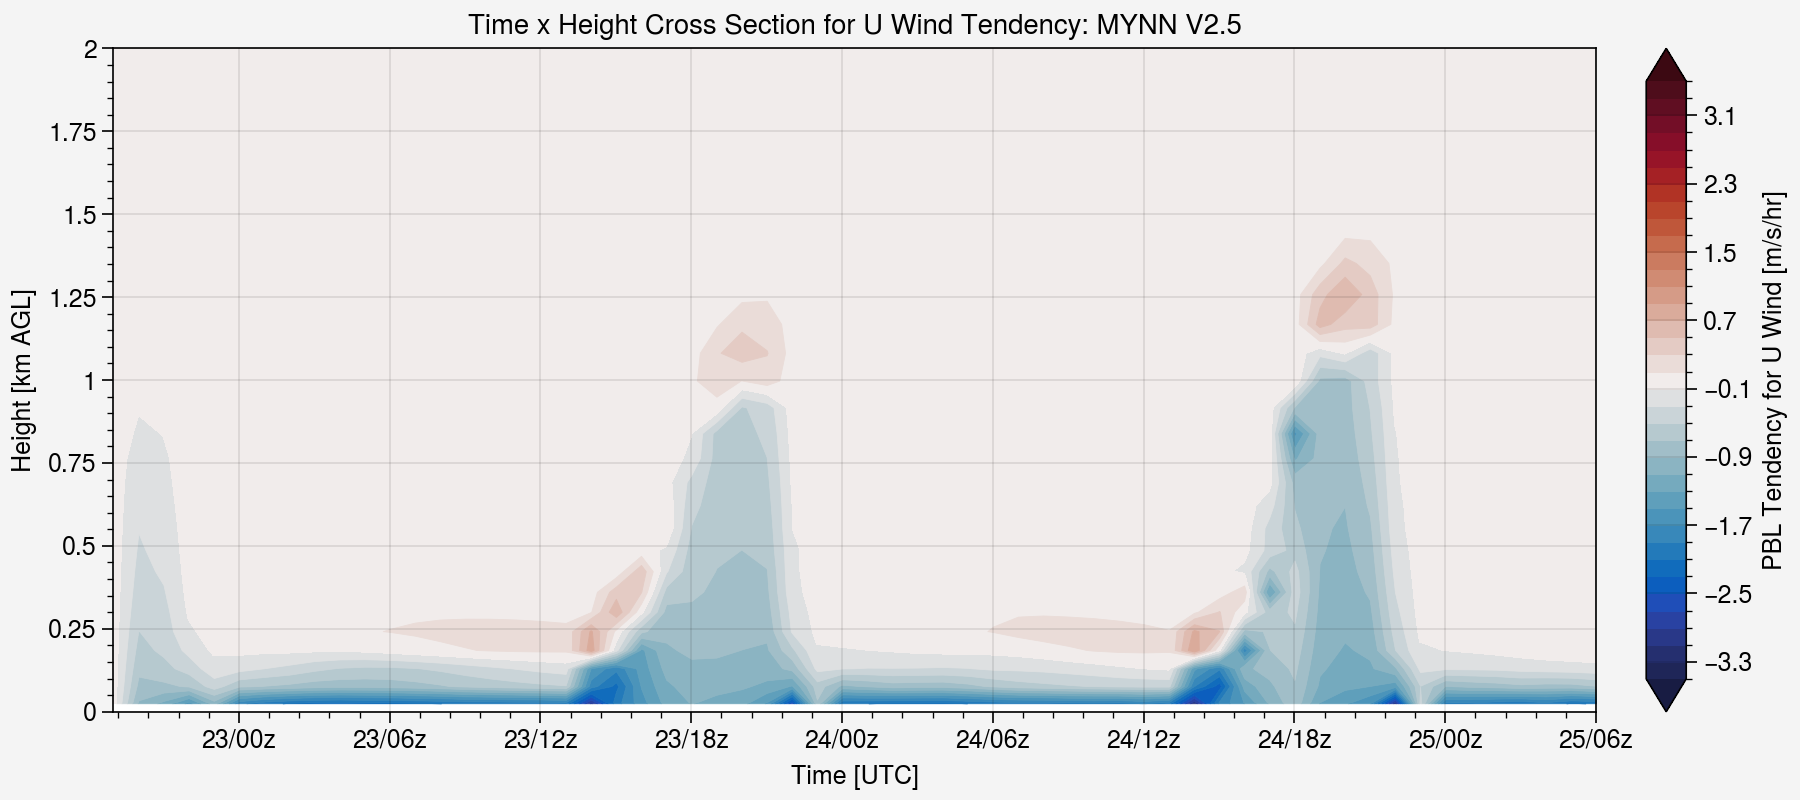

In [167]:

fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
fig.format(title=f"Time x Height Cross Section for U Wind Component: {scheme.upper()}")
time_values = d['Time'].values
height_values = d['geopotential_height'][0, :, 0, 0].values / 1000.
u_wind_values = d.variables['wind_east'][:, :, 0, 0].T.values
c = plt.contourf(time_values, height_values, u_wind_values, levels=np.arange(-20, 21, 1), cmap='Div', extend='both')

cb = axs.colorbar(c, label="U Wind Component [m/s]")
axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
fig.show()

# Plotting Time x Height Cross Section for U Wind Tendency from PBL Scheme
fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
fig.format(title=f"Time x Height Cross Section for U Wind Tendency: {scheme.upper()}")
u_tend = 3600 * pbl_u[:, :, 0, 0].T
c = plt.contourf(time_values, height_values, u_tend, levels=np.arange(-3.5, 3.7, 0.2), cmap='Balance', extend='both')

cb = axs.colorbar(c, label="PBL Tendency for U Wind [m/s/hr]", extend='both')
axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
fig.show()



# Plotting Time x Height Cross Section for V Wind Component


/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/1211302104.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/1211302104.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


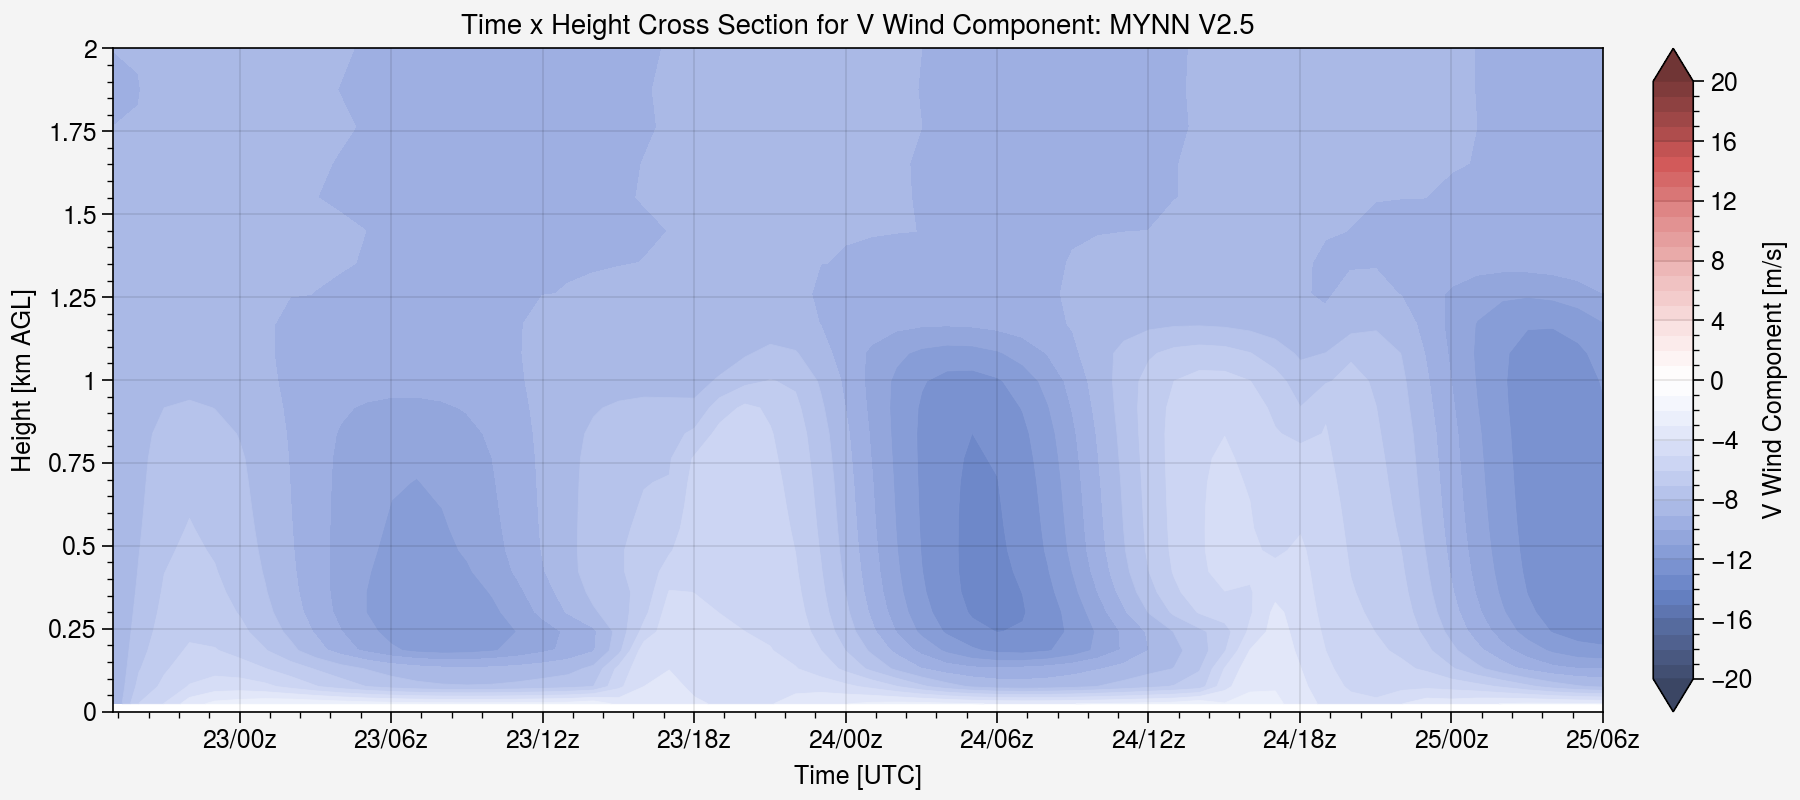

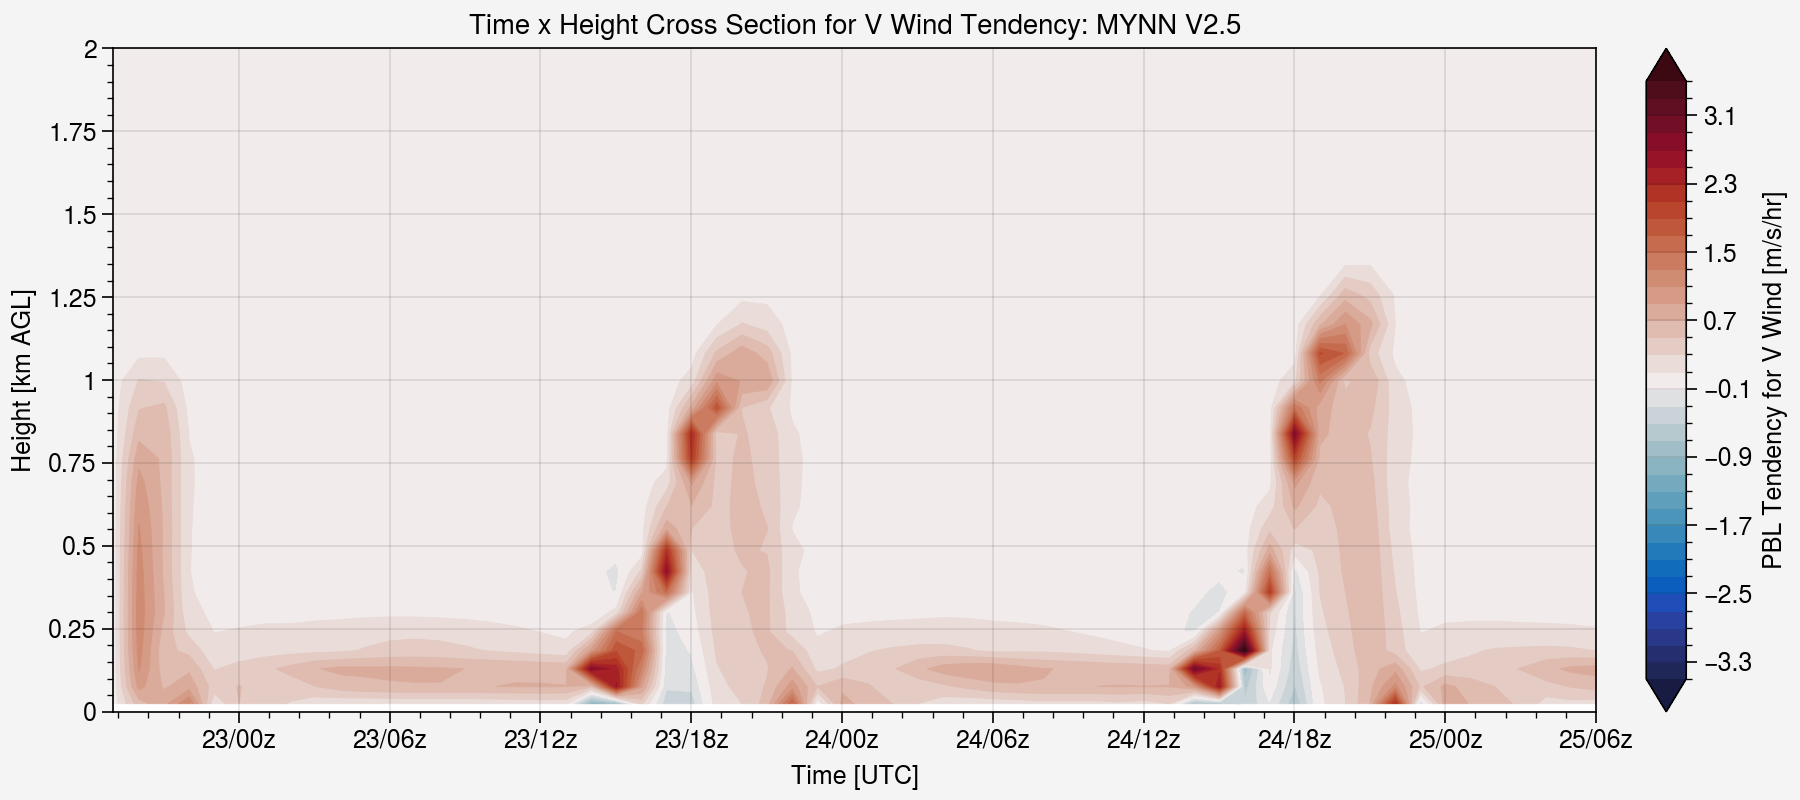

In [168]:
fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
fig.format(title=f"Time x Height Cross Section for V Wind Component: {scheme.upper()}")
v_wind_values = d.variables['wind_north'][:, :, 0, 0].T.values
c = plt.contourf(time_values, height_values, v_wind_values, levels=np.arange(-20, 21, 1), cmap='Div', extend='both')

cb = axs.colorbar(c, label="V Wind Component [m/s]")
axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
fig.show()

# Plotting Time x Height Cross Section for V Wind Tendency from PBL Scheme
fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
fig.format(title=f"Time x Height Cross Section for V Wind Tendency: {scheme.upper()}")
v_tend = 3600 * pbl_v[:, :, 0, 0].T
c = plt.contourf(time_values, height_values, v_tend, levels=np.arange(-3.5, 3.7, 0.2), cmap='Balance', extend='both')

cb = axs.colorbar(c, label="PBL Tendency for V Wind [m/s/hr]", extend='both')
axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
fig.show()

/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/732777687.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


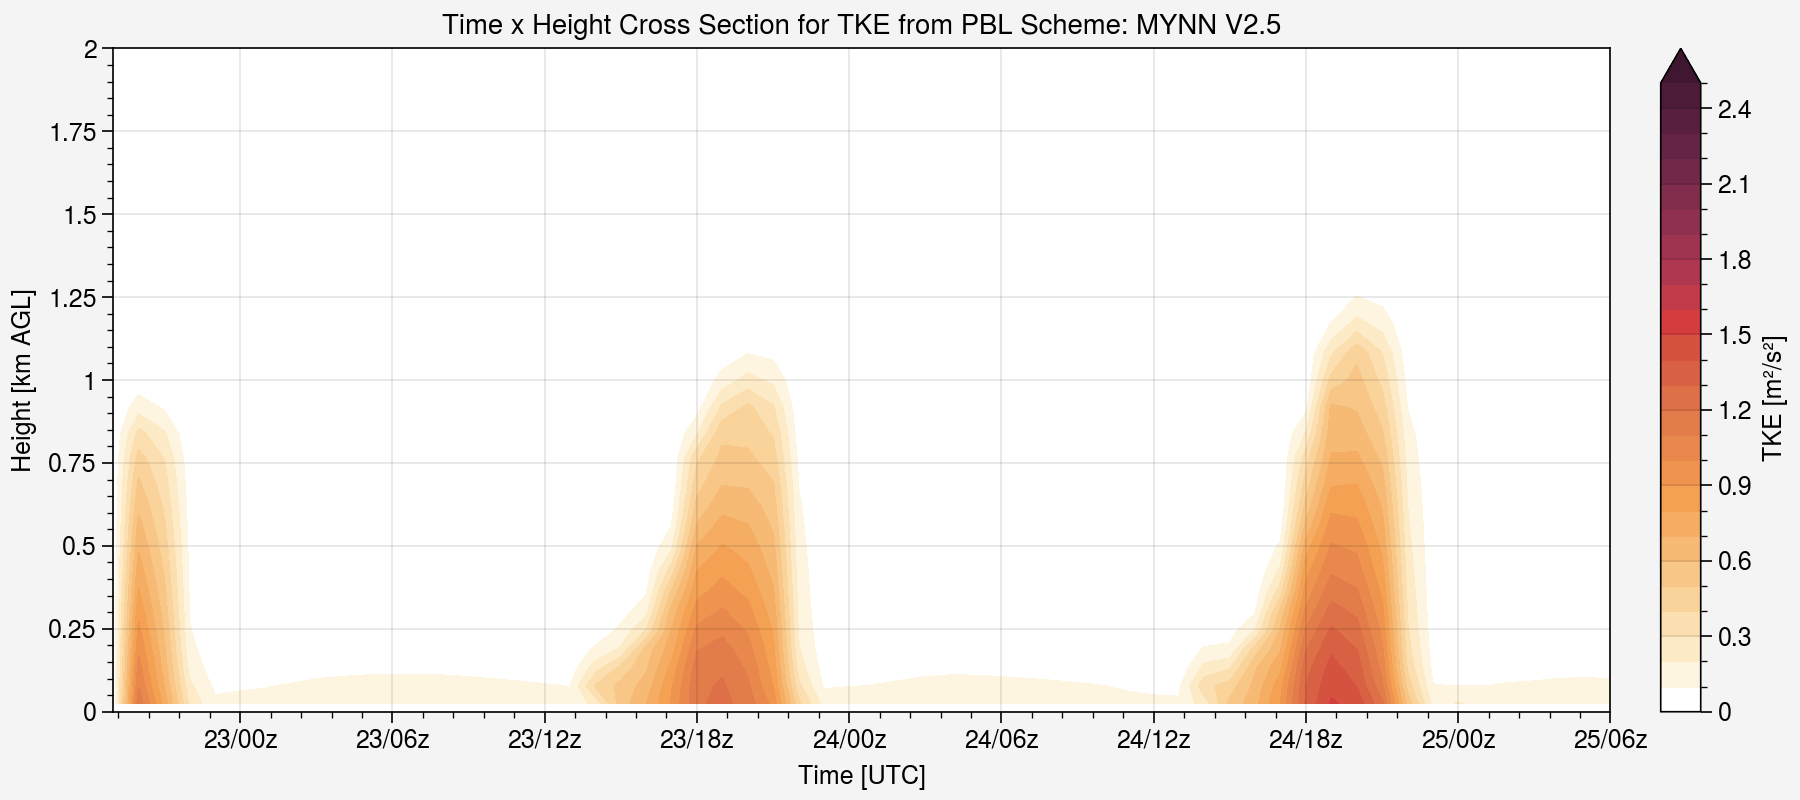

In [169]:
# Plotting Time x Height Cross Section for Turbulence Kinetic Energy (TKE) from PBL Scheme
fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
fig.format(title=f"Time x Height Cross Section for TKE from PBL Scheme: {scheme.upper()}")
time_values = d['Time'].values
height_values = d['geopotential_height'][0, :, 0, 0].values / 1000.
tke_values = tke_pbl[:, :, 0, 0].T
c = plt.contourf(time_values, height_values, tke_values/2., levels=np.arange(0, 2.6, 0.1), extend='max')

cb = axs.colorbar(c, label="TKE [m²/s²]")
axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
fig.show()

/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/3739016362.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


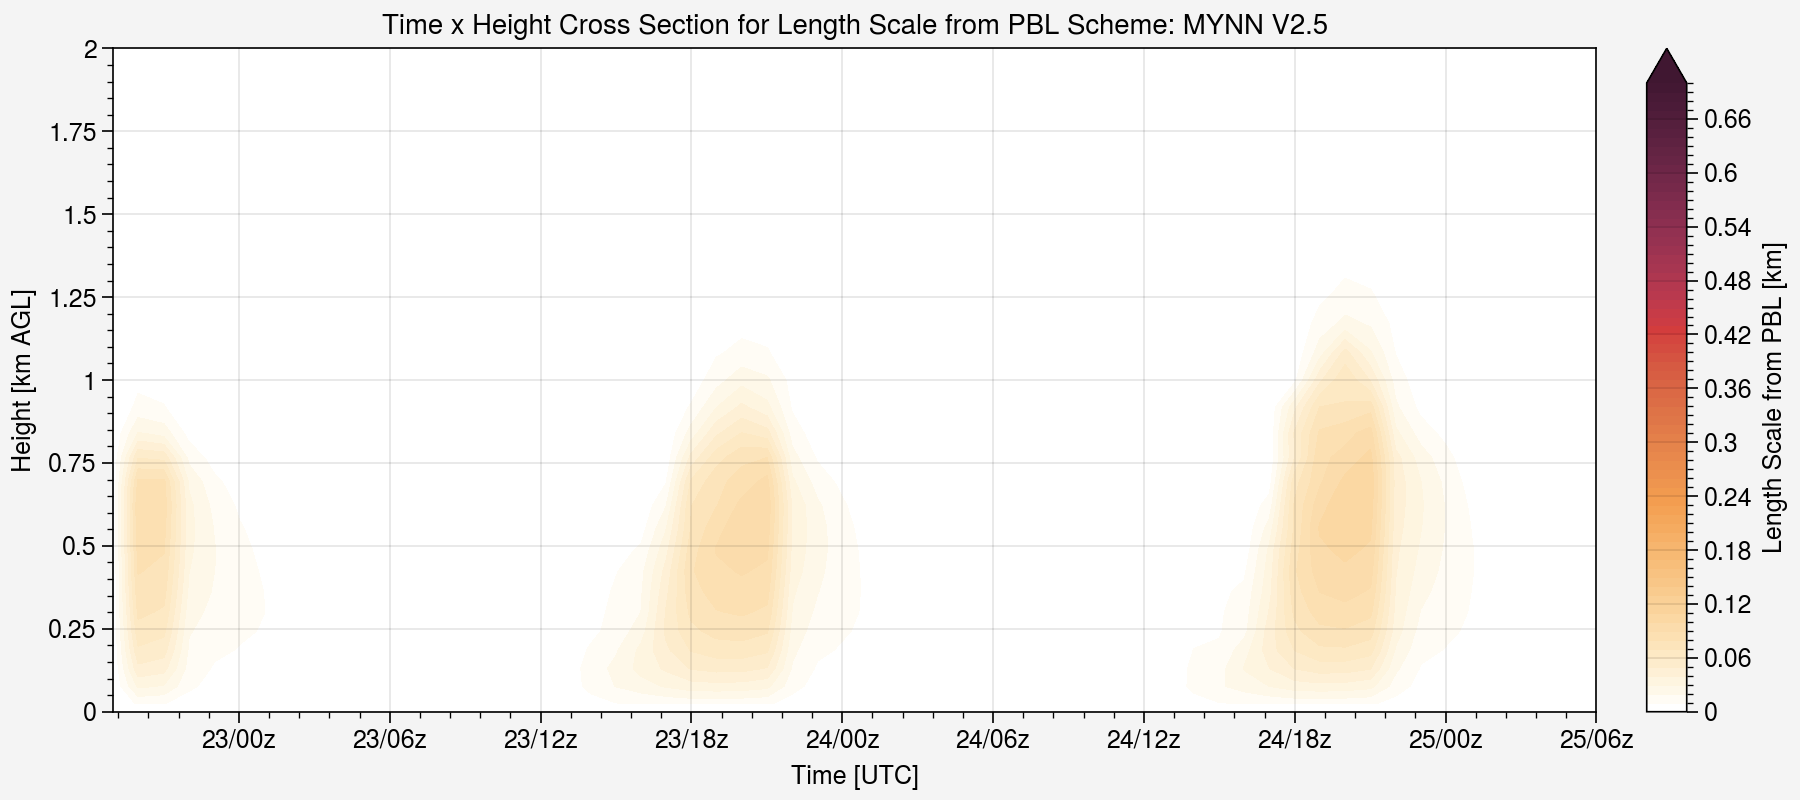

In [170]:
# Plotting Time x Height Cross Section for Length Scale from PBL Scheme
fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
fig.format(title=f"Time x Height Cross Section for Length Scale from PBL Scheme: {scheme.upper()}")
time_values = d['Time'].values
height_values = d['geopotential_height'][0, :, 0, 0].values / 1000.
values = el_pbl[:, :, 0, 0].T
c = plt.contourf(time_values, height_values, values/1000., levels=np.arange(0, .71, 0.01), extend='max')

cb = axs.colorbar(c, label="Length Scale from PBL [km]")
axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
fig.show()

In [173]:
if scheme == "BOULAC":
    #
    # Plotting Time x Height Cross Section for Turbulent Flux of Momentum (WU_TUR)
    fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
    fig.format(title=f"Time x Height Cross Section for Turbulent Flux of Momentum (WU_TUR): {scheme.upper()}")
    wu_tur_values = wu_tur[:, :, 0, 0].T
    c = plt.contourf(time_values, height_values, wu_tur_values, levels=np.arange(-0.4, 0.425, 0.025), cmap='Balance', extend='both')

    cb = axs.colorbar(c, label="Turbulent Flux of Momentum (WU_TUR) [m²/s²]", extend='both')
    axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
    fig.show()

    # Plotting Time x Height Cross Section for Turbulent Flux of Momentum (WV_TUR)
    fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
    fig.format(title=f"Time x Height Cross Section for Turbulent Flux of Momentum (WV_TUR): {scheme.upper()}")
    wv_tur_values = wv_tur[:, :, 0, 0].T
    c = plt.contourf(time_values, height_values, wv_tur_values, levels=np.arange(-0.4, 0.425, 0.025), cmap='Balance', extend='both')

    cb = axs.colorbar(c, label="Turbulent Flux of Momentum (WV_TUR) [m²/s²]", extend='both')
    axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
    fig.show()

    # Plotting Time x Height Cross Section for Turbulent Flux of Temperature (WT_TUR)
    fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
    fig.format(title=f"Time x Height Cross Section for Turbulent Flux of Temperature (WT_TUR): {scheme.upper()}")
    wt_tur_values = wt_tur[:, :, 0, 0].T
    c = plt.contourf(time_values, height_values, wt_tur_values, levels=np.arange(-0.1, 0.11, 0.01), cmap='Balance', extend='both')

    cb = axs.colorbar(c, label="Turbulent Flux of Temperature (WT_TUR) [K m/s]", extend='both')
    axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
    fig.show()

    # Plotting Time x Height Cross Section for Turbulent Flux of Water Vapor (WQ_TUR)
    fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
    fig.format(title=f"Time x Height Cross Section for Turbulent Flux of Water Vapor (WQ_TUR): {scheme.upper()}")
    wq_tur_values = 1000.*wq_tur[:, :, 0, 0].T
    c = plt.contourf(time_values, height_values, wq_tur_values, levels=np.arange(-0.1, 0.11, 0.01), cmap='Balance', extend='both')

    cb = axs.colorbar(c, label="Turbulent Flux of Water Vapor (WQ_TUR) [g/kg m/s]", extend='both')
    axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
    fig.show()

/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/2368276736.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/2368276736.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/2368276736.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_85783/2368276736.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


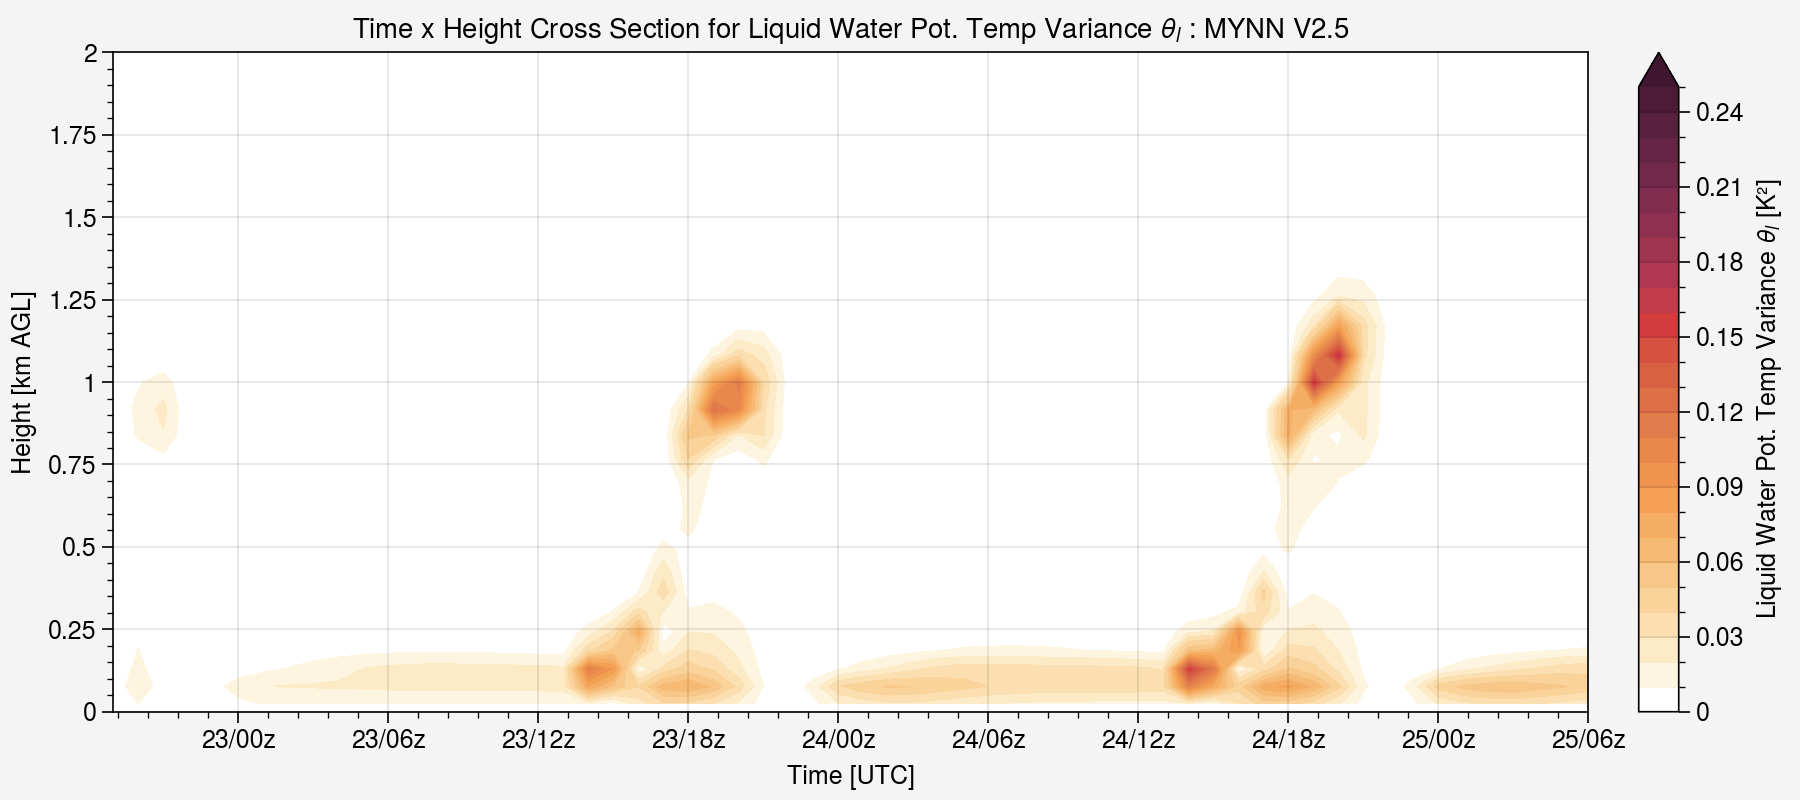

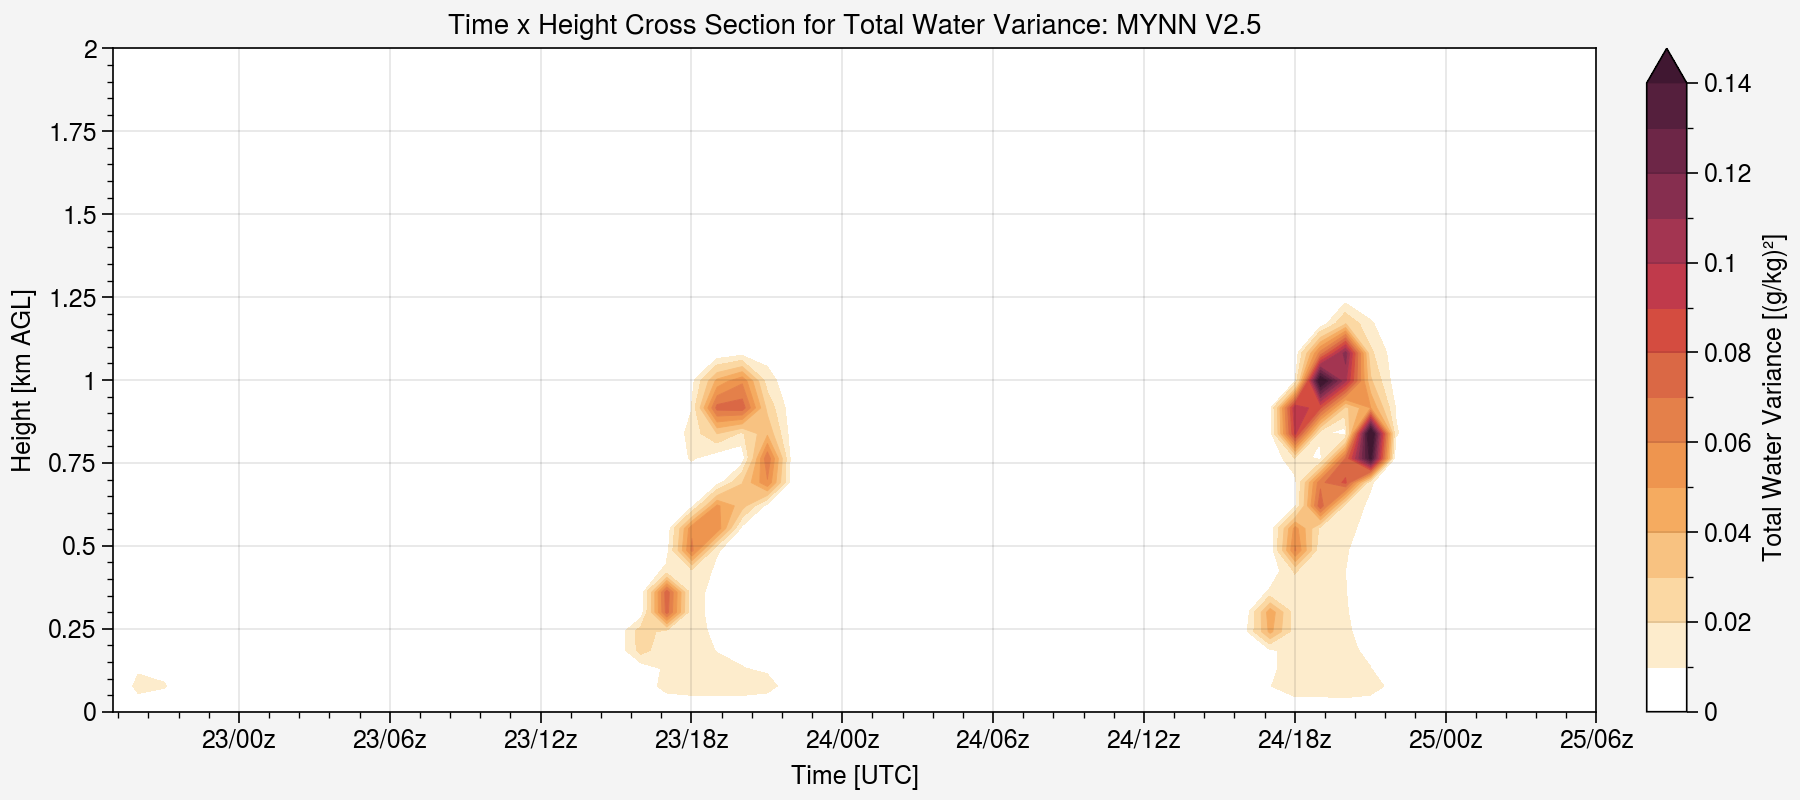

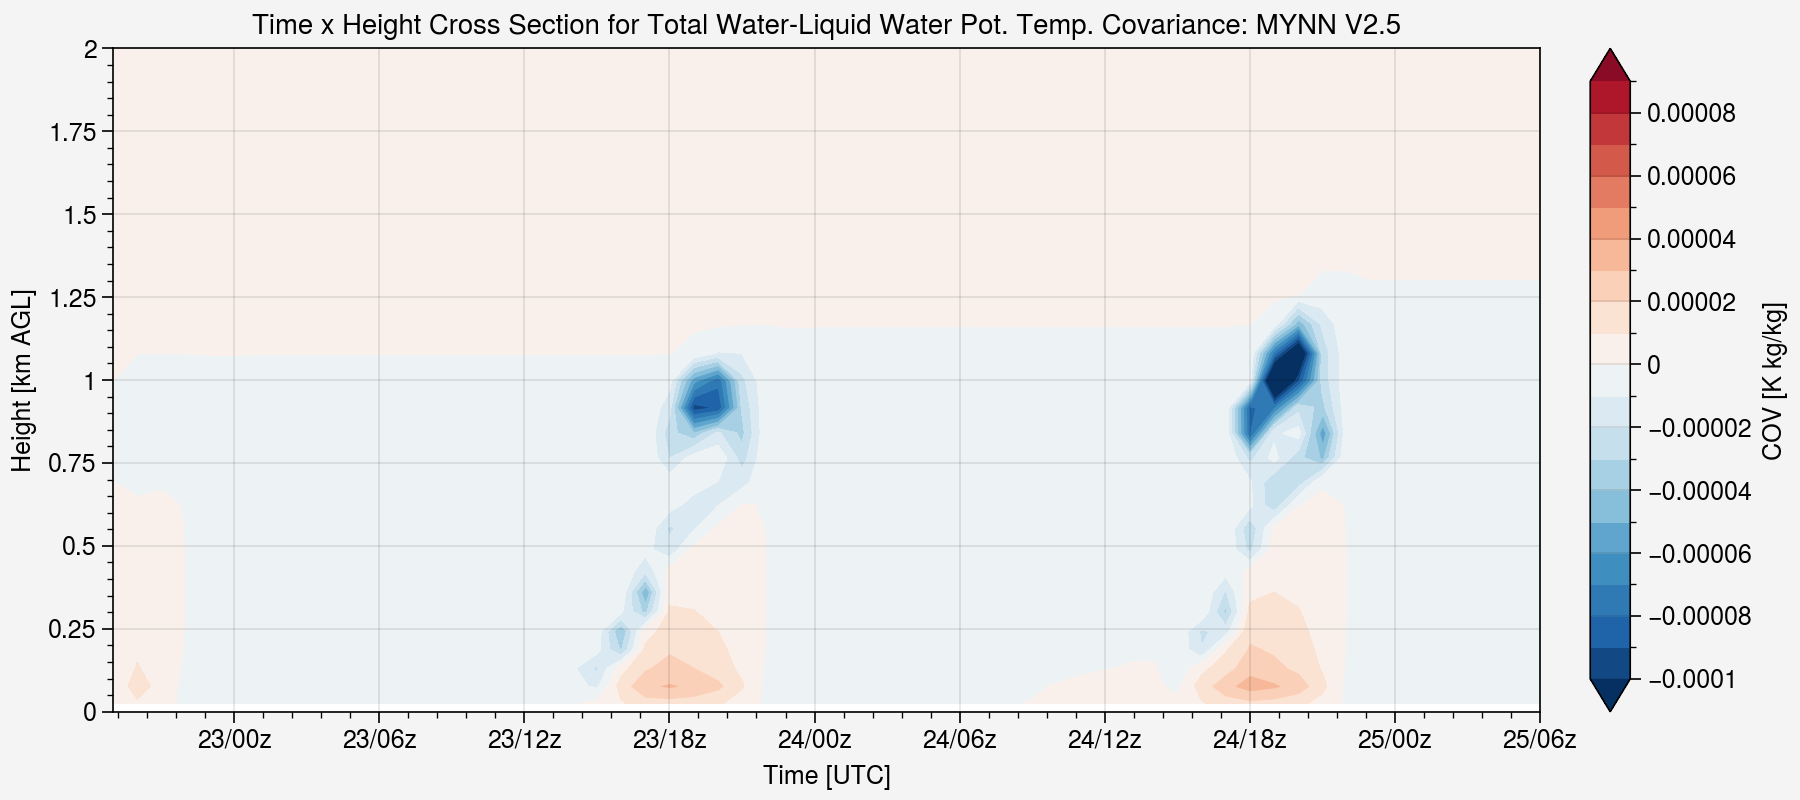

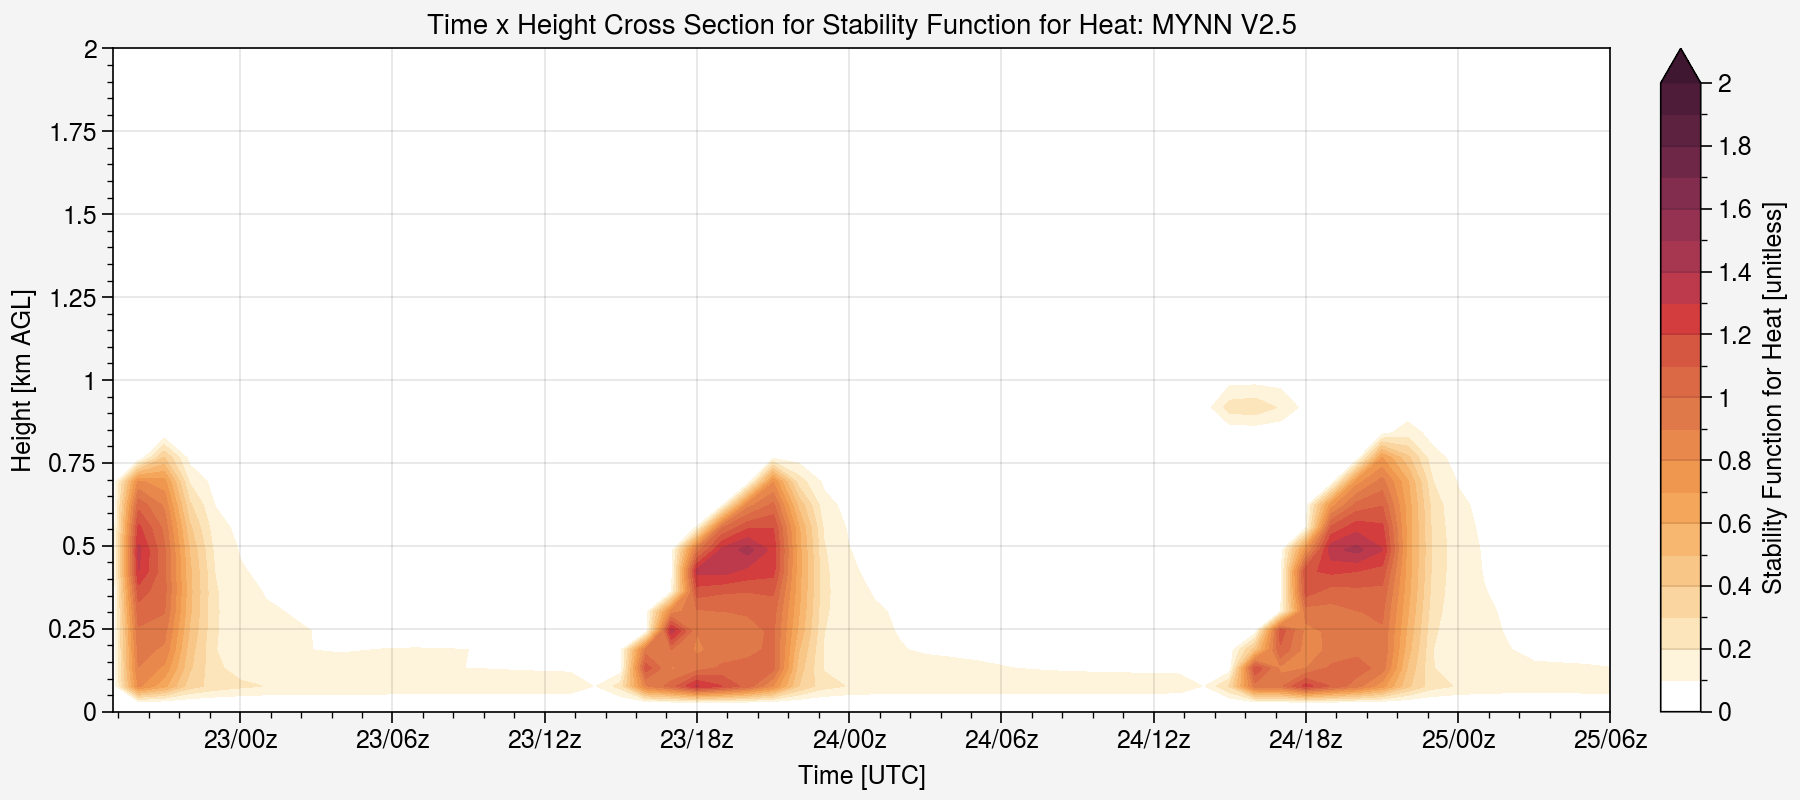

In [174]:
if "MYNN" in scheme:
    # Plotting Time x Height Cross Section for TSQ
    fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
    fig.format(title=f"Time x Height Cross Section for Liquid Water Pot. Temp Variance $\\theta_l$ : {scheme.upper()}")
    tsq_values = tsq[:, :, 0, 0].T
    c = plt.contourf(time_values, height_values, tsq_values, levels=np.arange(0, 0.26, 0.01), extend='max')
    cb = axs.colorbar(c, label="Liquid Water Pot. Temp Variance $\\theta_l$ [K²]")
    axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
    fig.show()

    # Plotting Time x Height Cross Section for QSQ
    fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
    fig.format(title=f"Time x Height Cross Section for Total Water Variance: {scheme.upper()}")
    qsq_values = qsq[:, :, 0, 0].T
    c = plt.contourf(time_values, height_values, 1000*1000*qsq_values, levels=np.arange(0, 0.15, 0.01), extend='max')
    cb = axs.colorbar(c, label="Total Water Variance [(g/kg)²]")
    axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
    fig.show()

    # Plotting Time x Height Cross Section for COV
    fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
    fig.format(title=f"Time x Height Cross Section for Total Water-Liquid Water Pot. Temp. Covariance: {scheme.upper()}")
    cov_values = cov[:, :, 0, 0].T
    c = plt.contourf(time_values, height_values, cov_values, levels=np.arange(-0.0001, 0.0001, 0.00001), extend='both')
    cb = axs.colorbar(c, label="COV [K kg/kg]")
    axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
    fig.show()

    # Plotting Time x Height Cross Section for SH3D
    fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(9,4), facecolor='w')
    fig.format(title=f"Time x Height Cross Section for Stability Function for Heat: {scheme.upper()}")
    sh3d_values = sh3d[:, :, 0, 0].T
    c = plt.contourf(time_values, height_values, sh3d_values, levels=np.arange(0, 2.1, 0.1), extend='max')
    cb = axs.colorbar(c, label="Stability Function for Heat [unitless]")
    axs.format(ylim=(0, 2), ylabel="Height [km AGL]", xlabel="Time [UTC]", xformatter='%d/%Hz', xrotation=0)
    fig.show()
